In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
clean = pd.read_csv('clean_sales_8811.csv')

In [3]:
clean.head()

,year,no_of_cylinders,horsepower,body_condition,mechanical_condition,color_Beige,color_Black,color_Blue,color_Brown,color_Burgundy,...,body_type_Van,body_type_Wagon,transmission_type_Automatic Transmission,transmission_type_Manual Transmission,fuel_type_Diesel,fuel_type_Electric,fuel_type_Gasoline,fuel_type_Hybrid,miles,price_usd
0,2013,6,-1,3,4,0,0,0,0,0,...,0,0,1,0,0,0,1,0,104011.29,7079.65
1,2018,8,4,3,4,0,0,0,0,0,...,0,0,1,0,0,0,1,0,24233.47,29952.35
2,2014,6,4,3,4,0,0,1,0,0,...,0,0,1,0,0,0,1,0,124274.20,21238.94
3,2018,8,6,3,4,0,0,0,0,0,...,0,0,1,0,0,0,1,0,16777.02,244792.38
4,2020,4,0,3,4,0,0,0,0,0,...,0,1,0,1,0,0,1,0,42874.60,8985.70


In [4]:
clean.shape

(8811, 43)

In [5]:
def train(df, model):
    """Train a machine learning model on the given data.

    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame containing the features and target variable.
    model : sklearn.ensemble.RandomForestRegressor
        The machine learning model to fit to the data.

    Returns
    -------
    fitted_model : sklearn.ensemble.RandomForestRegressor
        The trained machine learning model.
    X_test : pandas.DataFrame
        The input data frame containing only the test features.
    y_test : pandas.Series
        The target variable corresponding to the test features.
    """
    # Drop the 'price_usd' column from the features
    X = df.drop(columns='price_usd')

    # Select the 'price_usd' column as the target variable
    y = df['price_usd']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42, shuffle=True)

    # Fit the model on the training data
    fitted_model = model.fit(X_train, y_train)

    # Return the fitted model, along with the test features and test labels
    return fitted_model, X_test, y_test

In [6]:
def metrics(df, model):
    """
    Evaluates the performance of a given model on specified data. Returns regression metrics.

    Parameters:
    df : pandas.DataFrame: 
        The input data frame containing the features and target variable.
    model : sklearn.ensemble.RandomForestRegressor
        The machine learning model to fit to the data.
    
    train (function): Helper function to fit the model and generate predictions.

    Returns:
    dict: Contains evaluated regression metrics.
    """
    
    # Train the model and obtain predictions on the test set
    model, X_test, y_test = train(df, model)
    pred = model.predict(X_test)
    
    # Calculate regression metrics
    mean = df['price_usd'].mean().round(2)
    mae_goal = (mean * .05).round(2)
    mae = mean_absolute_error(y_test, pred).round(2)
    mae_diff = (mae - mae_goal).round(2)
    mape =  ((mae / mean) * 100).round(2)
    mean_abs_diff = np.mean(np.abs(np.diff(y_test)))
    mase = (mae / mean_abs_diff).round(2)
    mse = mean_squared_error(y_test, pred).round(2)
    rmse = np.sqrt(mse).round(2)
    r2 = r2_score(y_test, pred).round(2)
    
    # Print the calculated metrics
    print(f"""
Data Set Mean: {mean}\n
MAE Goal: {mae_goal}  MAE: {mae}  Difference: {mae_diff}\n
MAPE: {mape}%  MASE: {mase}\n
MSE: {mse}  RMSE: {rmse}\n
R2: {r2}
""")

In [74]:
def plot_accuracy(df, model):
    """
    Plots the actual vs predicted values for a given dataset and model.

    Parameters:
    df : pandas.DataFrame: 
        The input data frame containing the features and target variable.
    model : sklearn.ensemble.RandomForestRegressor
        The machine learning model to fit to the data.

    Returns:
    None
    """
    
    # Train the model and obtain test data
    model, X_test, y_test = train(df, model)
    
    # Make predictions using the trained model
    pred = model.predict(X_test)
    
    # Calculate the percentage difference
    percentage_difference = np.abs((pred - y_test) / y_test) * 100

    # Create masks for each category
    mask_within_5pct = percentage_difference <= 5
    mask_over_prediction = pred > y_test
    mask_under_prediction = ~mask_within_5pct & ~mask_over_prediction

    # Define the colors for each category
    color_within_5pct = '#377eb8'
    color_over_prediction = '#4daf4a'
    color_under_prediction = '#ff7f00'

    # Scatter plots for each category
    scatter_within_5pct = plt.scatter(y_test[mask_within_5pct], pred[mask_within_5pct], alpha=0.5, label="Within 5%", color=color_within_5pct)
    scatter_over_prediction = plt.scatter(y_test[mask_over_prediction], pred[mask_over_prediction], alpha=0.5, label="Over Prediction", color=color_over_prediction)
    scatter_under_prediction = plt.scatter(y_test[mask_under_prediction], pred[mask_under_prediction], alpha=0.5, label="Under Prediction", color=color_under_prediction)

    # Calculate the coefficients for the linear polynomial that best fits our data
    coefficients = np.polyfit(y_test, pred, deg=1)

    # Use the coefficients to generate the fit line
    fit_line_x = np.linspace(min(y_test), max(y_test))
    fit_line_y = coefficients[0]*fit_line_x + coefficients[1]
    plt.plot(fit_line_x, fit_line_y, linestyle='--', color='black', label='Fit Line')
    
    # Add common elements to the plot
    plt.legend(loc='upper left')
    plt.title('Scatter Plot of Predictions vs Actual Values with Fit Line')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

In [8]:
# Instantiate the Random Forest Model
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Provide data to our previously created 'metrics' function
metrics(clean, model)


Data Set Mean: 46380.58

MAE Goal: 2319.03  MAE: 17272.82  Difference: 14953.79

MAPE: 37.24%  MASE: 0.34

MSE: 828601558.0  RMSE: 28785.44

R2: 0.76



In [9]:
# Define lists and ranges covering desired hyperparameters

# Generate a list of integers representing possible 'n_estimators' values
n_est = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

max_feat = [1.0, 'sqrt']

# Create a list 'max_depth' with integer values obtained by calling 'np.linspace' method
# Range goes from 5 to 50 with 11 steps
max_depth = [int(x) for x in np.linspace(5, 50, num = 11)]

# Append 'None' to the end of the 'max_depth' list
max_depth.append(None)

min_samp_split = [2, 5, 10, 20]
min_samp_leaf = [1, 2, 4, 8]
bootstrap = [True, False]

# Organize hyperparameters into nested dictionaries
r_grid = {
    # Number of trees in the forest
    'n_estimators': n_est,
    
    # Maximum number of features considered when looking for the best split
    'max_features': max_feat,
    
    # Maximum depth of the individual regression estimators
    'max_depth': max_depth,
    
    # Minimum number of samples required to split an internal node
    'min_samples_split': min_samp_split,
    
    # Minimum number of samples required to be a leaf node
    'min_samples_leaf': min_samp_leaf,
    
    # Whether bootstrap samples are used when building trees
    'bootstrap': bootstrap
}

In [10]:
# Create a RandomizedSearchCV model with specified parameters
model_random = RandomizedSearchCV(
    estimator = model, param_distributions = r_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

# Train the RandomizedSearchCV model and obtain test set
model_random, X_test, y_test = train(clean, model_random)

# Print the best hyperparameters found by RandomizedSearchCV
model_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 900,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 18,
 'bootstrap': True}

In [11]:
# Use the best estimator from RandomizedSearchCV
best_random = model_random.best_estimator_

# Evaluate metrics on the cleaned dataset using the best estimator
metrics(clean, best_random)


Data Set Mean: 46380.58

MAE Goal: 2319.03  MAE: 14764.14  Difference: 12445.11

MAPE: 31.83%  MASE: 0.29

MSE: 660506554.15  RMSE: 25700.32

R2: 0.81



In [12]:
# Initialize a dictionary 'p_grid' for storing hyperparameters
p_grid = {
    'n_estimators': [800, 850, 900],
    'max_features': ['sqrt', 2, 3],
    'max_depth': [18, 19, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True]
}

# Perform grid search over specified hyperparameters with cross validation
model_grid = GridSearchCV(estimator = model, param_grid = p_grid, cv = 3, n_jobs = -1, verbose = 2)

# Train the model using training data and perform grid search
model_grid, X_test, y_test = train(clean, model_grid)

# Get the best hyperparameters found during grid search
model_grid.best_params_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


{'bootstrap': True,
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

In [13]:
# Obtain the best model according to grid search results
best_grid = model_grid.best_estimator_

# Evaluate metrics on the cleaned dataset using the best estimator
metric_value = metrics(clean, best_grid)


Data Set Mean: 46380.58

MAE Goal: 2319.03  MAE: 14764.7  Difference: 12445.67

MAPE: 31.83%  MASE: 0.29

MSE: 660856506.11  RMSE: 25707.13

R2: 0.81



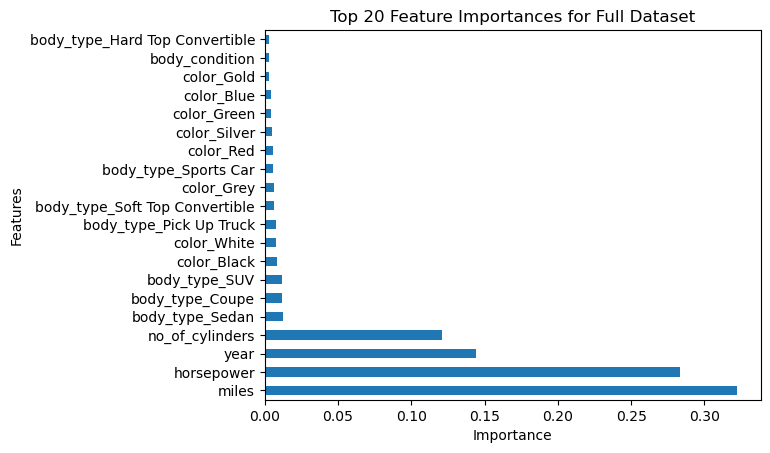

In [77]:
# Extract feature importances from the best model
feat_importance = pd.Series(best_grid.feature_importances_, index=X_test.columns)

# Sort features and plot top 20 feature importances
top_feats = feat_importance.nlargest(20)
ax = top_feats.plot(kind='barh')

plt.title("Top 20 Feature Importances for Full Dataset")
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show();

In [15]:
# Calculate quartiles for the target variable 'price_usd' in 'clean' DataFrame
high = clean['price_usd'].quantile(.75)
low = clean['price_usd'].quantile(.25)

# Compute interquartile spread
spread = (low, high)

print("Lower Quartile (Q1):", low)
print("Upper Quartile (Q3):", high)
print("Interquartile Spread (IQR):", spread)

Lower Quartile (Q1): 13070.12
Upper Quartile (Q3): 50646.7
Interquartile Spread (IQR): (13070.12, 50646.7)


In [16]:
# Filter rows based on IQR of 'price_usd'
clean75 = clean[(clean['price_usd'] > low) & (clean['price_usd'] < high)]

clean75.shape



(4361, 43)

In [17]:
# Instantiate, fit, and evaluate base Random Forest Regressor model with IQR dataset
model75 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Assess the fitted model's performance utilizing metrics function
metrics(clean75, model75)


Data Set Mean: 27120.12

MAE Goal: 1356.01  MAE: 6633.11  Difference: 5277.1

MAPE: 24.46%  MASE: 0.56

MSE: 69331590.33  RMSE: 8326.56

R2: 0.36



In [18]:
# Set up Hyperparameter Tuning for IQR dataset with Randomized Search CV
model_random75 = RandomizedSearchCV(
    estimator = model, param_distributions = r_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

model_random75, X_test, y_test = train(clean75, model_random75)

model_random75.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [19]:
# Retrieve the highest performing model unveiled by the RandomizedSearchCV process
best_random75 = model_random75.best_estimator_

# Measure the performance of the fine-tuned model against the IQR dataset
metrics(clean75, best_random75)


Data Set Mean: 27120.12

MAE Goal: 1356.01  MAE: 6358.13  Difference: 5002.12

MAPE: 23.44%  MASE: 0.53

MSE: 66678381.06  RMSE: 8165.68

R2: 0.39



In [20]:
# Set up Hyperparameter Tuning for IQR dataset with Grid Search CV
p_grid = {
    'n_estimators': [800, 850, 900],
    'max_features': ['sqrt', 2, 3],
    'max_depth': [18, 19, 20],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True]
}

model_grid75 = GridSearchCV(estimator = model, param_grid = p_grid, cv = 3, n_jobs = -1, verbose = 2)

model_grid75, X_test, y_test = train(clean75, model_grid75)

model_grid75.best_params_

Fitting 3 folds for each of 243 candidates, totalling 729 fits


{'bootstrap': True,
 'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 900}

In [21]:
# Retrieve the highest performing model unveiled by the GridSearchCV process
best_grid75 = model_grid.best_estimator_

# Measure the performance of the fine-tuned model against the IQR dataset
metrics(clean75, best_grid75)


Data Set Mean: 27120.12

MAE Goal: 1356.01  MAE: 6334.14  Difference: 4978.13

MAPE: 23.36%  MASE: 0.53

MSE: 64951779.93  RMSE: 8059.27

R2: 0.4



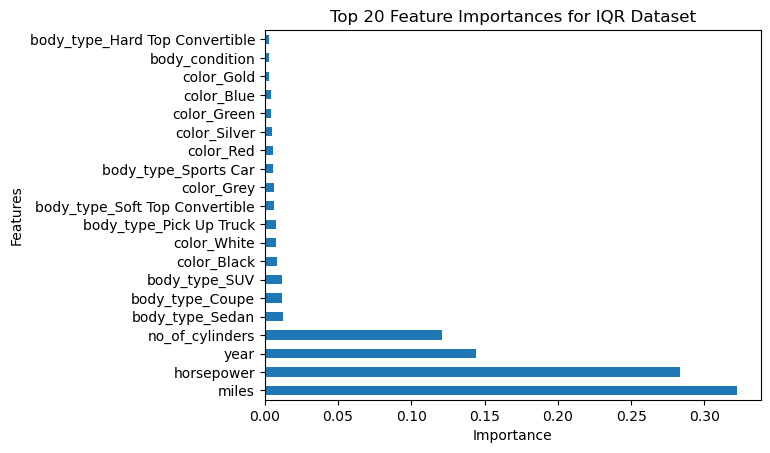

In [78]:
# Extract feature importances from the best model
feat_importance75 = pd.Series(best_grid75.feature_importances_, index=X_test.columns)

# Sort features and plot top 20 feature importances
top_feats75 = feat_importance75.nlargest(20)
ax = top_feats75.plot(kind='barh')

plt.title("Top 20 Feature Importances for IQR Dataset")
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show();

In [23]:
# Select Top 10 Features from Entire Dataset Based on Their Relative Importance Scores
reduced_columns = ['price_usd']
for x in feat_importance.nlargest(10).index:
    reduced_columns.append(x)

# Pick Top 10 Features from Filtered Dataset Based on Their Relative Importance Scores
reduced_columns75 = ['price_usd']
for x in feat_importance75.nlargest(10).index:
    reduced_columns75.append(x)

print("Reduced Columns:", reduced_columns)
print("\nReduced Columns for Clean75:", reduced_columns75)

Reduced Columns: ['price_usd', 'miles', 'horsepower', 'year', 'no_of_cylinders', 'body_type_Sedan', 'body_type_Coupe', 'body_type_SUV', 'color_Black', 'color_White', 'body_type_Pick Up Truck']

Reduced Columns for Clean75: ['price_usd', 'miles', 'year', 'horsepower', 'no_of_cylinders', 'body_type_SUV', 'color_Black', 'body_type_Sedan', 'color_White', 'body_type_Coupe', 'color_Grey']


In [24]:
# Create datasets with only the top 10 features included
clean_reduced = clean[reduced_columns]
clean_reduced75 = clean75[reduced_columns75]

In [25]:
# Test reduced features on full dataset
metrics(clean_reduced, best_grid)


Data Set Mean: 46380.58

MAE Goal: 2319.03  MAE: 14645.48  Difference: 12326.45

MAPE: 31.58%  MASE: 0.29

MSE: 656747850.61  RMSE: 25627.09

R2: 0.81



In [26]:
# Test reduced features on IQR dataset
metrics(clean_reduced75, best_grid75)


Data Set Mean: 27120.12

MAE Goal: 1356.01  MAE: 6474.08  Difference: 5118.07

MAPE: 23.87%  MASE: 0.54

MSE: 71067303.27  RMSE: 8430.14

R2: 0.35



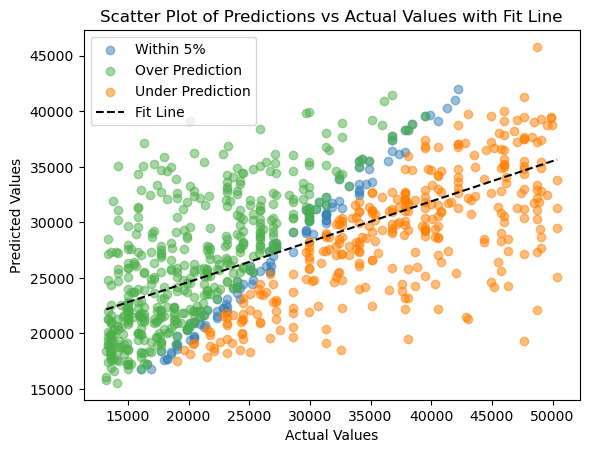

In [75]:
plot_accuracy(clean75, best_grid75)

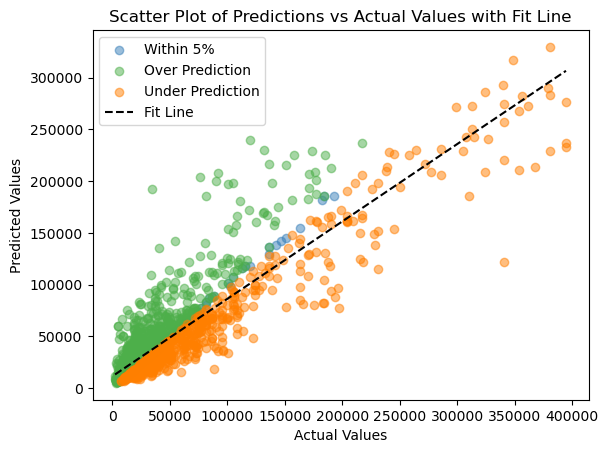

In [76]:
plot_accuracy(clean, best_grid)